In [1]:
# IMPORT LIBRARIES

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
import matplotlib.pyplot as plt
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table


# DATA LOADER

class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=False):
        if self.oo == None or self.new != new:
            self.new = new
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        
        DATA = True
        return x,y,VR,Vphi,R,Lz,phi

# Initialize data loader
l = Loader()


# AUXILIARY FUNCTIONS

# Group the data into bins in x and get the average y for each bin
def smooth_bins(x, y, xmin, xmax, binsize):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

# Get an equispaced curve from a number of points
def curve_from_bins(nx, ny, N):
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    return xpol, ypol

# Perform Fourier transform on a curve
def fourier_from_curve(xpol, ypol):
    N = len(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((xpol[-1]-xpol[0]) / abs(xf * N))
    return xfr, yf

Text(0.5, 0, 'Frequency of $V_R/L_z$')

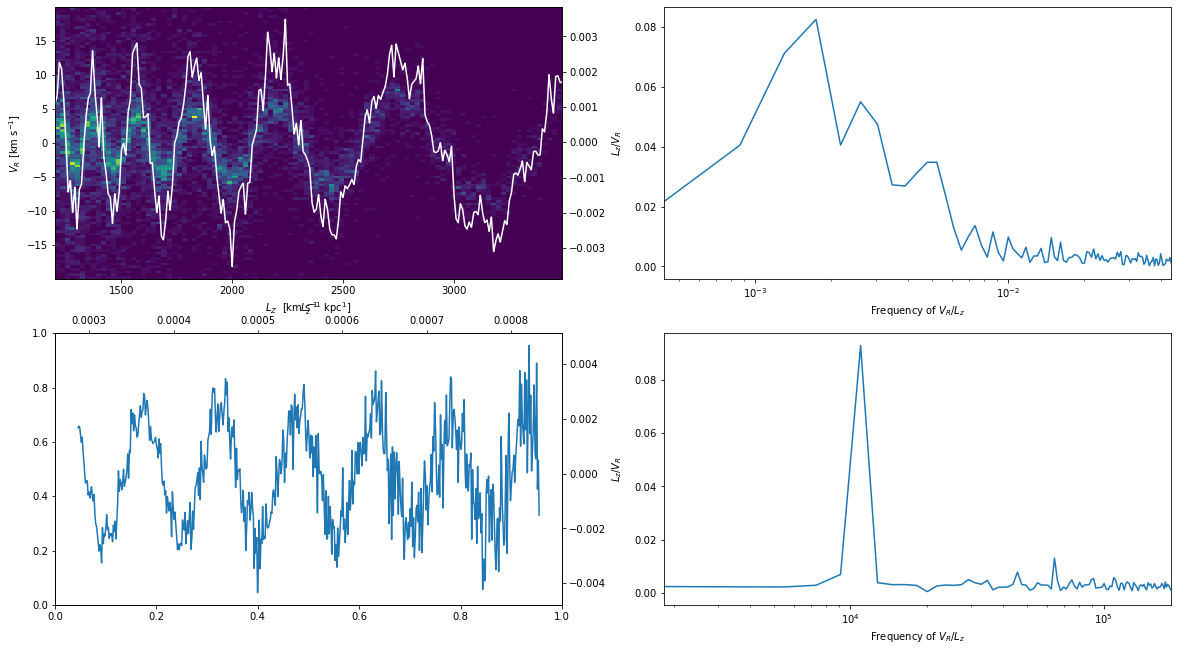

In [2]:
# Plot untransformed and transformed (with Lz**nexp) simulation data, and their Fourier transforms

# Load model
TIME = 2.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

fig, ax = plt.subplots(2,2,figsize=(20,11))

# Background histogram
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
ax[0][0].hist2d(Lz, VR, bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

# Fourier analysis, untransformed
nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

# Plot Fourier
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')
ax[0][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[0][1].set_xlim(1/max(xfr), 1/xfr[100])
ax[0][1].set_xscale('log')
ax[0][1].set_aspect('auto')
ax[0][1].set_xlabel('Frequency of $V_R/L_z$')

# Fourier analysis, transformed
nexp = -1
nx, ny = smooth_bins(Lz**nexp, VR/Lz, np.min(Lz**nexp), np.max(Lz**nexp), 1e-6)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

# Plot Fourier
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')
ax[1][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[1][1].set_xlim(1/max(xfr), 1/xfr[100])
ax[1][1].set_xscale('log')
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Frequency of $V_R/L_z$')


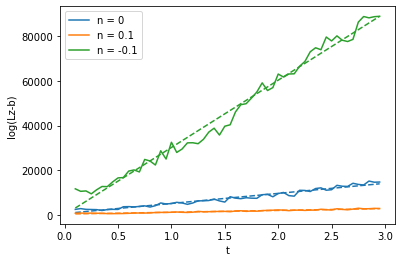

In [4]:
# Evolution of the frequency of the highest peak in the Fourier transform with time
# (after transformation with **(n+1)/(n-1)), for different models

model_labels = ['n = 0', 'n = 0.1', 'n = -0.1']
ns = [0,0.1,-0.1]
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10']):
#for model_i, model in enumerate(['Dhotn_10_pn_10']):
    
    times = np.arange(0.1, 3.0, 0.05)
    vtimes = list(times)
    freqs = []
    freqs2 = []

    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False
        
        n = ns[model_i]
        nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
        N = 100000
        xpol, ypol = curve_from_bins(nx, ny, N)
        xfr, yf = fourier_from_curve(xpol, ypol)
        
        CUT = 5
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)
        #if (1/freq < 2 and time > 2):
        #    print(time,1/freq)
        CUT = 0
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)


    #plt.plot(times, 1/np.array(freqs2))
    plt.plot(vtimes, 1/np.array(freqs), c=f'C{model_i}', label=model_labels[model_i])

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C{model_i}', ls='--')

plt.xlabel('t')
plt.ylabel('Lz**(n+1)/(n-1)')
plt.legend()

Text(0, 0.5, 'Lz**(n+1)/(n-1)')

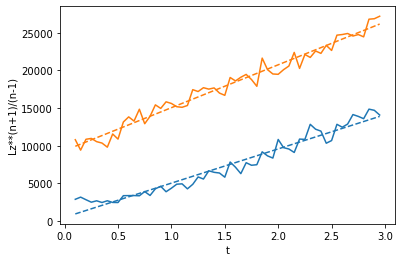

In [6]:
# Evolution of the frequency of the highest and second-highest peaks in the Fourier transform with time
# (after transformation with **(n+1)/(n-1)), for the two perturbations model

for model_i, model in enumerate(['Dhot_log_2perturb']):
    
    times = np.arange(0.1, 3.0, 0.05)
    vtimes = list(times)
    freqs = []
    freqs2 = []

    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

        n = 0
        nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
        N = 100000
        xpol, ypol = curve_from_bins(nx, ny, N)
        xfr, yf = fourier_from_curve(xpol, ypol)
        
        CUT = 5
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)
        #if (1/freq < 2 and time > 2):
        #    print(time,1/freq)
        CUT = 4
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        yf2 = np.copy(yf)
        yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
        relxfr = xfr[max(0,abs(yf2).argmax()-CUT):abs(yf2).argmax()+CUT+1]
        relyf = yf[max(0,abs(yf2).argmax()-CUT):abs(yf2).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)


    plt.plot(vtimes, 1/np.array(freqs), c='C0')
    plt.plot(vtimes, 1/np.array(freqs2), c='C1')

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C0', ls='--')
    fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C1', ls='--')

plt.xlabel('t')
plt.ylabel('Lz**(n+1)/(n-1)')

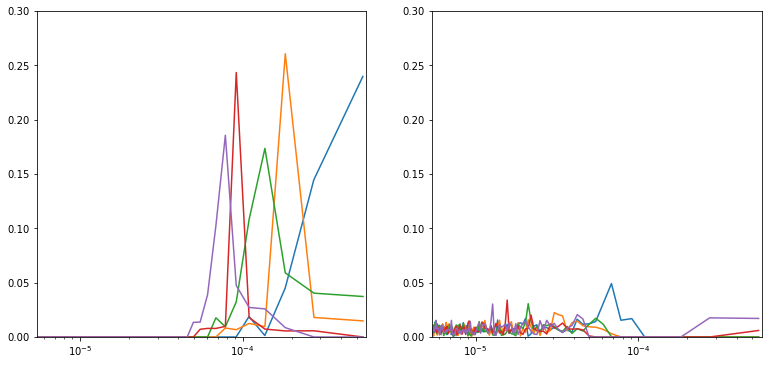

In [10]:
# Superposition of the Fourier transforms for different times (and also removing the highest peak)

CURMODEL = 'Dhot_log'
eps = 0.01
times = np.arange(0.5, 2.5+eps, 0.5)
freqs = []
freqs2 = []
fig, ax = plt.subplots(1,2,figsize=(13,6))

for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
    N = 100000
    xpol, ypol = curve_from_bins(nx, ny, N)
    xfr, yf = fourier_from_curve(xpol, ypol)
    
    CUT=4
    yf2 = np.copy(yf)
    yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
    
    ax[0].plot(xfr, 2.0/N * np.abs(yf-yf2))
    ax[1].plot(xfr, 2.0/N * np.abs(yf2))
    for a in ax:
        a.set_xlim(xfr[100])
        a.set_ylim(0, 0.3)
        a.set_xscale('log')
    #plt.xaxis.set_major_formatter(ticker.ScalarFormatter())
